In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('../../data/raw/Retail_Sales_Data.csv')

df.columns


Index(['retailer', 'store_id', 'week', 'product', 'description',
       'regular_price', 'competition_1_regular_price',
       'competition_2_regular_price', 'competition_3_regular_price',
       'competition_4_regular_price', 'competition_5_regular_price',
       'competition_6_regular_price', 'competition_7_regular_price',
       'competition_8_regular_price', 'competition_9_regular_price',
       'competition_10_regular_price', 'promo_price',
       'competition_1_promo_price', 'competition_2_promo_price',
       'competition_3_promo_price', 'competition_4_promo_price',
       'competition_5_promo_price', 'competition_6_promo_price',
       'competition_7_promo_price', 'competition_8_promo_price',
       'competition_9_promo_price', 'competition_10_promo_price', 'value',
       'volume', 'quantity'],
      dtype='object')

In [23]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

# Custom Transformer for Label Encoding specific columns
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {col: LabelEncoder() for col in columns}
    
    def fit(self, X, y=None):
        for col in self.columns:
            self.encoders[col].fit(X[col])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = self.encoders[col].transform(X_copy[col])
        return X_copy

# Load data
df = pd.read_csv('../../data/raw/Retail_Sales_Data.csv')

# Replace NaN promo prices with regular prices in competitor columns
for i in range(1, 11):
    promo_column = f'competition_{i}_promo_price'
    regular_column = f'competition_{i}_regular_price'
    if promo_column in df.columns and regular_column in df.columns:
        df[promo_column] = df[promo_column].fillna(df[regular_column])

# Drop 'value', 'volume', and 'description' columns
df = df.drop(columns=['value', 'volume', 'description'])

# Define feature and target columns
X = df.drop(columns=['quantity'])
y = df['quantity']

# Identify numeric and categorical columns, label encoding only the `product` column
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in X.select_dtypes(include=['object']).columns if col != 'product']
label_encode_features = ['product']

# Preprocessing pipeline with label encoding for product
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean for numeric features
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent for other categorical features
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),
        ('label', CustomLabelEncoder(columns=label_encode_features), label_encode_features)
    ])

# Define the pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Feature importance
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
model = pipeline.named_steps['regressor']
coefficients = model.coef_

# Feature importance table
feature_importance = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance Based on Linear Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

# Display feature importance table
print("Feature Importance Table:")
print(feature_importance)



Mean Squared Error (MSE): 15.733128406346347
Mean Absolute Error (MAE): 3.2380650929972425
R-squared (R²): 0.0017083623061878717


AttributeError: Transformer label (type CustomLabelEncoder) does not provide get_feature_names_out.

Mean Squared Error (MSE): 15.79146821144176
Mean Absolute Error (MAE): 3.238871934151619
R-squared (R²): -0.0019933896955275365


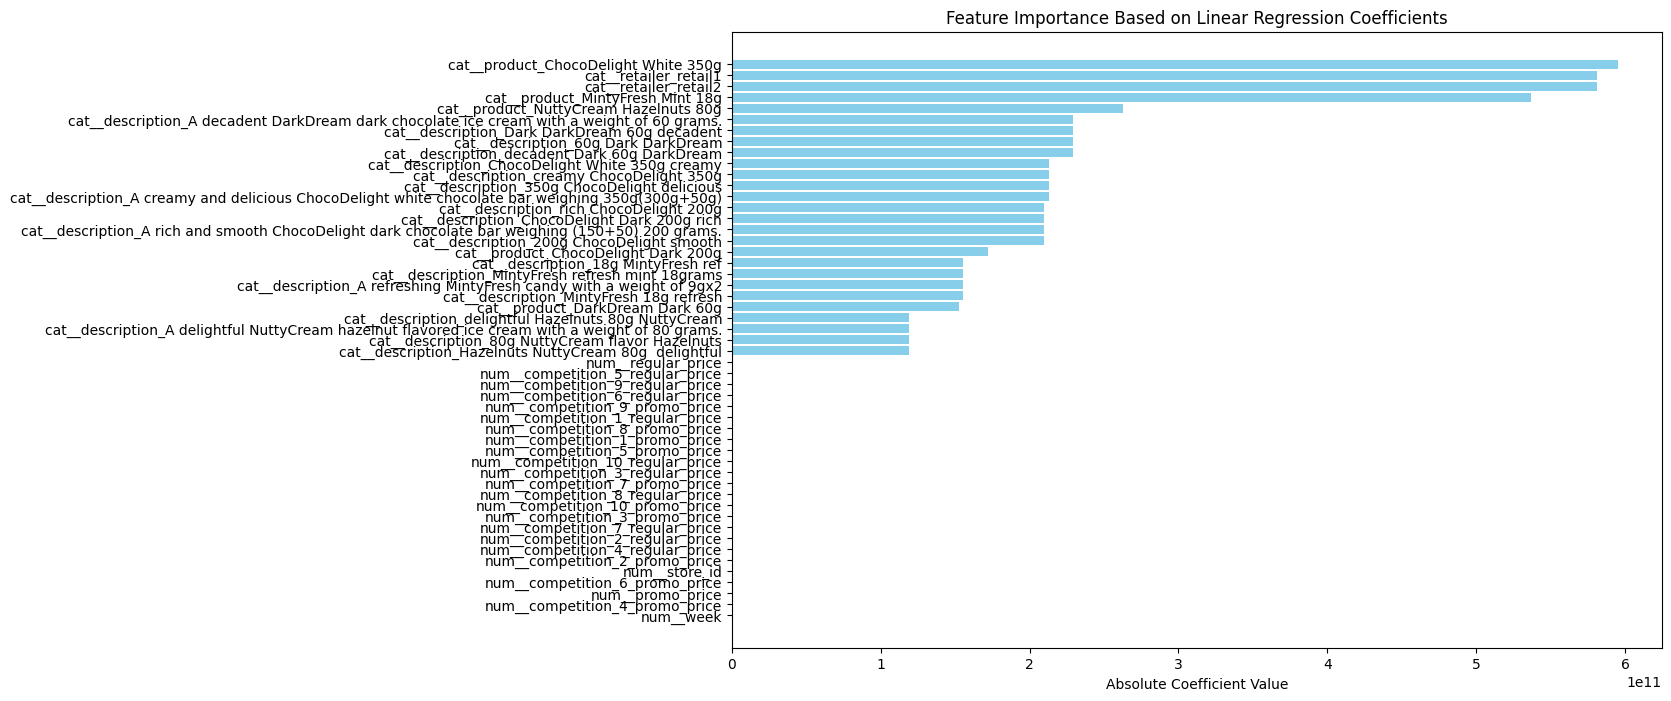

Feature Importance Table:
                                              Feature   Coefficient  \
27               cat__product_ChocoDelight White 350g  5.949016e+11   
24                              cat__retailer_retail1  5.813691e+11   
25                              cat__retailer_retail2  5.813691e+11   
29                   cat__product_MintyFresh Mint 18g  5.368483e+11   
30              cat__product_NuttyCream Hazelnuts 80g  2.625552e+11   
37  cat__description_A decadent DarkDream dark cho...  2.289124e+11   
43       cat__description_Dark DarkDream 60g decadent  2.289124e+11   
34                cat__description_60g Dark DarkDream  2.289124e+11   
48       cat__description_decadent Dark 60g DarkDream  2.289124e+11   
42    cat__description_ChocoDelight White 350g creamy -2.132453e+11   
47          cat__description_creamy ChocoDelight 350g -2.132453e+11   
33       cat__description_350g ChocoDelight delicious -2.132453e+11   
36  cat__description_A creamy and delicious ChocoD.

In [20]:
# Define feature and target columns
X = df.drop(columns=['quantity'])
y = df['quantity']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline with imputation step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean for numeric features
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent for categorical features
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Define the pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Feature importance
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
model = pipeline.named_steps['regressor']
coefficients = model.coef_

# Feature importance table
feature_importance = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance Based on Linear Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

# Display feature importance table
print("Feature Importance Table:")
print(feature_importance)


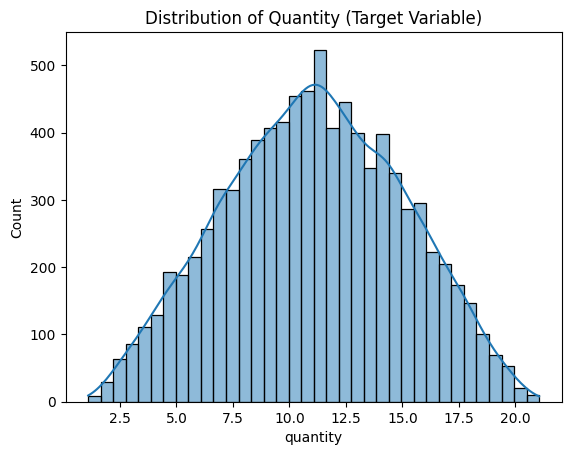

/tmp/ipykernel_2013/2737475691.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


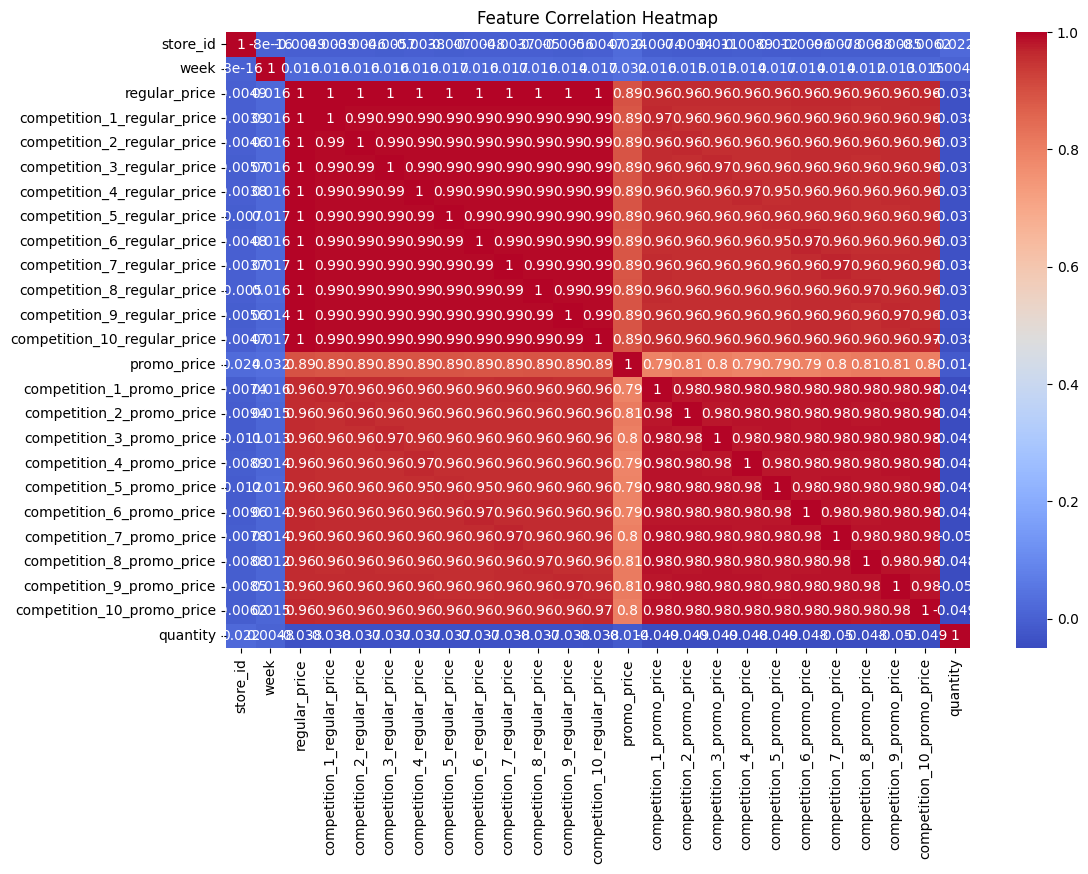

VIF for Numeric Features:
                         feature           VIF
0                       store_id      3.738762
1                           week      3.700802
2                  regular_price  11885.234827
3    competition_1_regular_price   1256.401650
4    competition_2_regular_price   1366.503145
5    competition_3_regular_price   1234.408676
6    competition_4_regular_price   1268.603179
7    competition_5_regular_price   1279.666531
8    competition_6_regular_price   1311.968657
9    competition_7_regular_price   1226.522294
10   competition_8_regular_price   1358.305770
11   competition_9_regular_price   1311.423470
12  competition_10_regular_price   1312.958901
13                   promo_price     37.740915
14     competition_1_promo_price     40.322144
15     competition_2_promo_price     38.414628
16     competition_3_promo_price     40.652294
17     competition_4_promo_price     38.840857
18     competition_5_promo_price     39.422287
19     competition_6_promo_price  

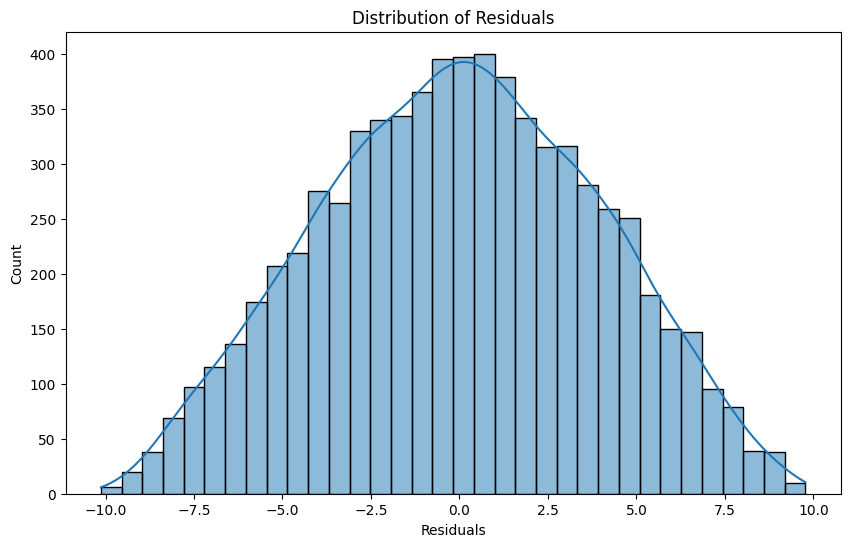

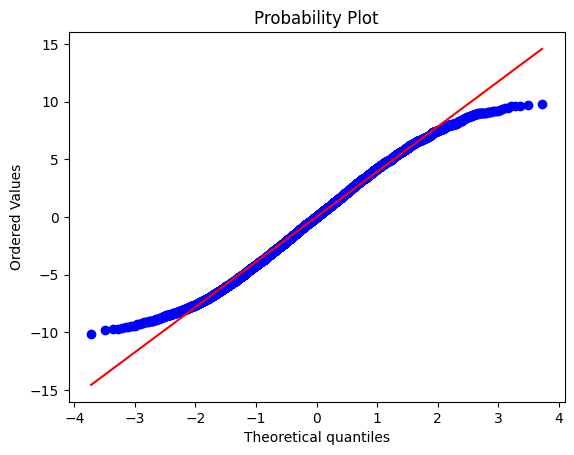

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from scipy.stats import probplot

# 1. Check distribution of target
sns.histplot(y, kde=True)
plt.title("Distribution of Quantity (Target Variable)")
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. Variance Inflation Factor (VIF) for Numeric Features
X_numeric = df[numeric_features].dropna()  # Ensure no NaNs in numeric features for VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print("VIF for Numeric Features:")
print(vif_data)

# 4. Residual Analysis
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
residuals = y_train - y_train_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.show()

# Probability plot for residuals
probplot(residuals, dist="norm", plot=plt)
plt.show()

# Log transformation suggestion if quantity is highly skewed
df['log_quantity'] = np.log1p(df['quantity'])


In [12]:
# Define feature and target columns
X = df.drop(columns=['quantity'])
y = df['quantity']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Extract feature names after one-hot encoding for interpretation
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get the coefficients from the trained model
model = pipeline.named_steps['regressor']
coefficients = model.coef_

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
}).sort_values(by='Absolute Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance Based on Linear Regression Coefficients')
plt.gca().invert_yaxis()
plt.show()

# Display feature importance table
print("Feature Importance Table:")
print(feature_importance)



ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### XGBoost model with Created Features

In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the processed dataset
df = pd.read_csv('../../data/processed/processed_data_with_features.csv')

# Define features (X) and target (y)
X = df.drop(columns=['quantity'])  # Assuming `quantity` is the target variable
y = df['quantity']

# One-hot encode categorical columns
categorical_features = ['retailer', 'product']
X = pd.get_dummies(X, columns=categorical_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 0.07572932237782096
Mean Absolute Error (MAE): 0.2264304114819862
R-squared (R²): 0.46210284384776834


In [49]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Parameter grid
param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBoost model
xgb = XGBRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print best parameters and performance
print("Best Parameters:", random_search.best_params_)
print("Best MSE:", -random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=  13.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   8.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0; total time=  10.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0; total time=   9.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=1.0; total time=   9.0s
[CV] EN

In [50]:
# Retrieve the best parameters from random search
best_params = random_search.best_params_

# Initialize and train the model with best parameters
xgb_best = XGBRegressor(**best_params, random_state=42)
xgb_best.fit(X_train, y_train)

# Predict and evaluate
y_pred_best = xgb_best.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model - Mean Squared Error (MSE): {mse_best}")
print(f"Best Model - Mean Absolute Error (MAE): {mae_best}")
print(f"Best Model - R-squared (R²): {r2_best}")


Best Model - Mean Squared Error (MSE): 0.07559033424987889
Best Model - Mean Absolute Error (MAE): 0.22660651591460354
Best Model - R-squared (R²): 0.4630900614328666


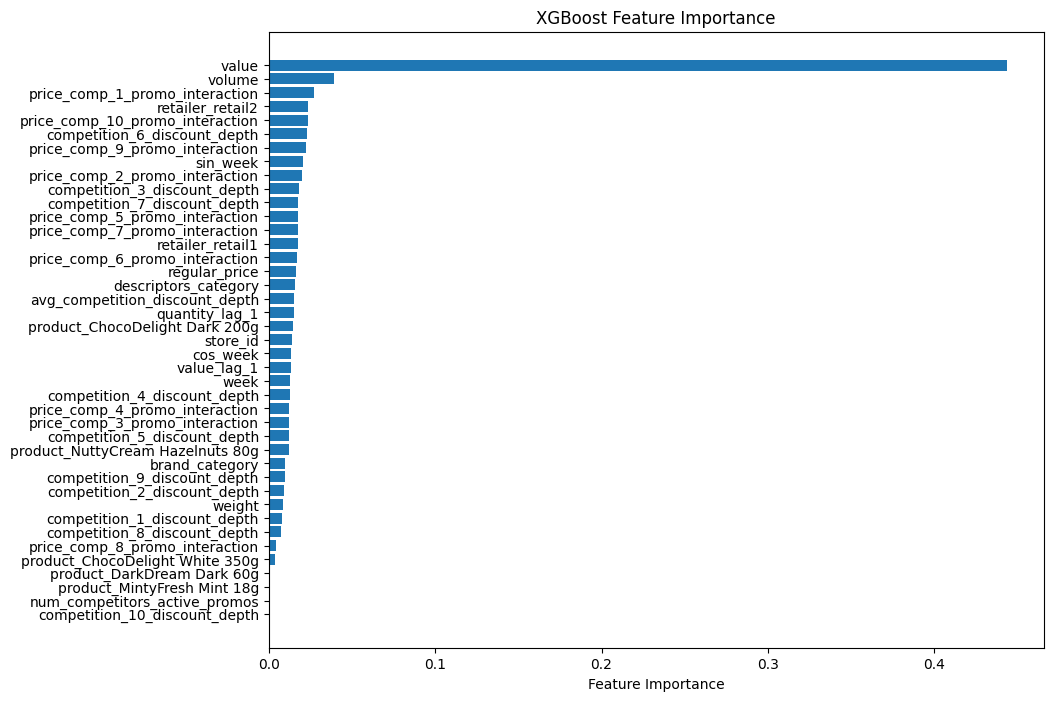

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the trained model
feature_importance = xgb_best.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

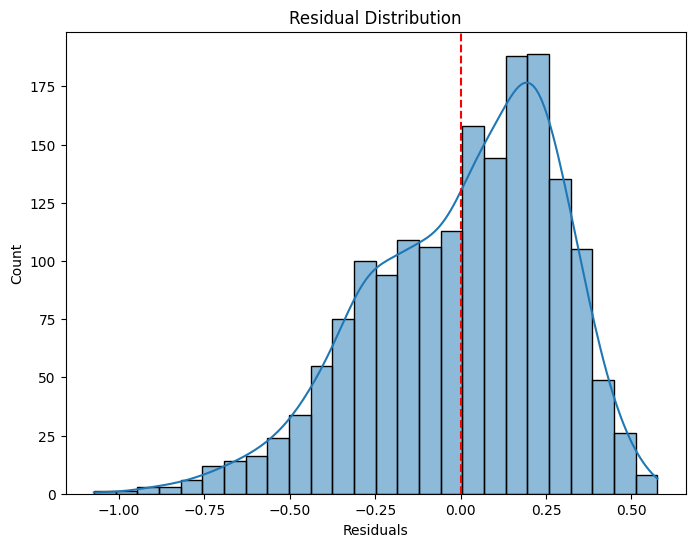

In [52]:
# Calculate residuals
residuals = y_test - y_pred_best

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()

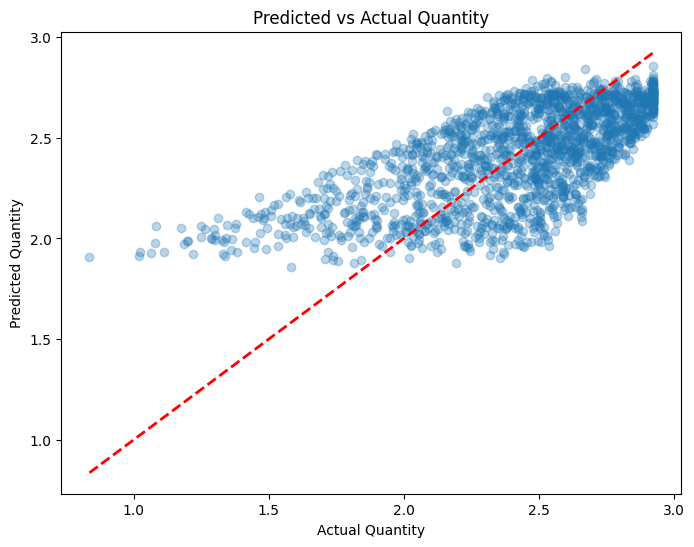

In [53]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Quantity")
plt.ylabel("Predicted Quantity")
plt.title("Predicted vs Actual Quantity")
plt.show()


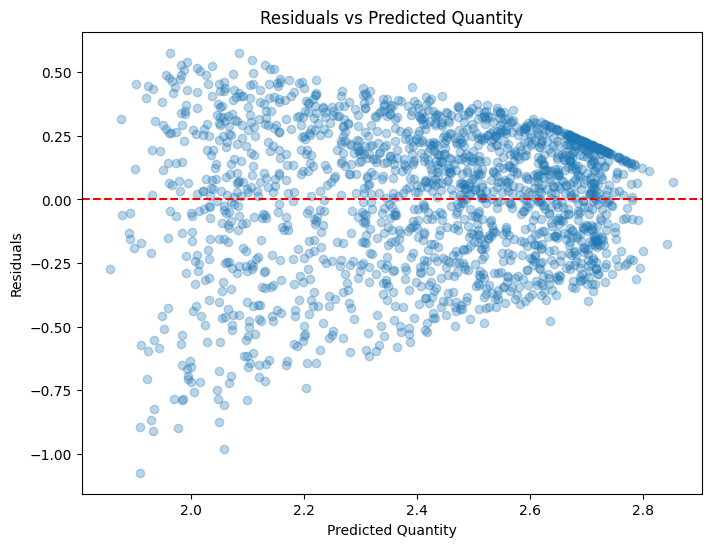

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_best, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Quantity")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Quantity")
plt.show()

In [57]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Step 1: Log Transformation of the Target Variable
df['log_quantity'] = np.log(df['quantity'] + 1)  # Adding 1 to avoid log(0) issues

# Define features (X) and the transformed target (y)
X = df.drop(columns=['quantity', 'log_quantity'])  # Remove original and log-transformed target from features
y = df['log_quantity']

# Step 2: Encode categorical features
X_encoded = pd.get_dummies(X, columns=['retailer', 'product'], drop_first=True)

# Train-Test Split with Validation Set
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Convert the data into XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Parameters for XGBoost including regularization
params = {
    "objective": "reg:squarederror",
    "alpha": 0.1,           # L1 regularization
    "lambda": 0.1,          # L2 regularization
    "learning_rate": 0.05,  # Reduced learning rate for fine-tuning
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

# Step 3: Train the model with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals,
                  early_stopping_rounds=50, verbose_eval=False)

# Make predictions on the validation set
y_pred_log = model.predict(dval)

# Convert predictions back to original scale
y_pred = np.exp(y_pred_log) - 1  # Reverse log transformation

# Step 4: Evaluate Model Performance
mse = mean_squared_error(np.exp(y_val) - 1, y_pred)  # Use original scale for comparison
mae = mean_absolute_error(np.exp(y_val) - 1, y_pred)
r2 = r2_score(np.exp(y_val) - 1, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")




Mean Squared Error (MSE): 0.07593950441706704
Mean Absolute Error (MAE): 0.22730854971913234
R-squared (R²): 0.4606099436390395
